In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-19 02:06:55--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.06s   

2025-10-19 02:06:55 (1.21 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [40]:
df = pd.read_csv("/Users/jimmytran/Documents/ml-zoomcamp/04-evaluation/course_lead_scoring.csv")

In [18]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [41]:
numerical = ["number_of_courses_viewed", "annual_income", "interaction_count", "lead_score"]
categorical = ["lead_source", "industry", "employment_status", "location"]
df[numerical] = df[numerical].fillna(0.0)
df[categorical] = df[categorical].fillna('NA')
df

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,0.0,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NA,5,71016.0,self_employed,north_america,0,0.25,1


In [42]:
from sklearn.model_selection import train_test_split

In [43]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_full_train = df_full_train['converted'].values
y_test = df_test['converted'].values

In [44]:
from sklearn.metrics import roc_auc_score

In [45]:
for col in numerical:
    print(col, roc_auc_score(y_train, df_train[col]))

number_of_courses_viewed 0.7635680590007088
annual_income 0.5519578313253012
interaction_count 0.738270176293409
lead_score 0.6144993577250176


In [63]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [66]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
scaler = StandardScaler()
X_train = scaler.fit_transform(dv.fit_transform(train_dict))
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
val_dict =  df_val[categorical + numerical].to_dict(orient='records')
X_val = scaler.transform(dv.transform(val_dict))
y_pred = model.predict_proba(X_val)[:, 1]
print(roc_auc_score(y_val, y_pred))




0.9208608954079187


In [69]:
thresholds = np.linspace(0,1.0,101)
precisions = []
recalls = []
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precisions.append(tp/(tp+fp))
    recalls.append(tp/(tp+fn))

    

/var/folders/n1/xgc8tbq94fddm0hzc5ytyqj80000gn/T/ipykernel_69772/165227161.py:16: RuntimeWarning: invalid value encountered in scalar divide
  precisions.append(tp/(tp+fp))


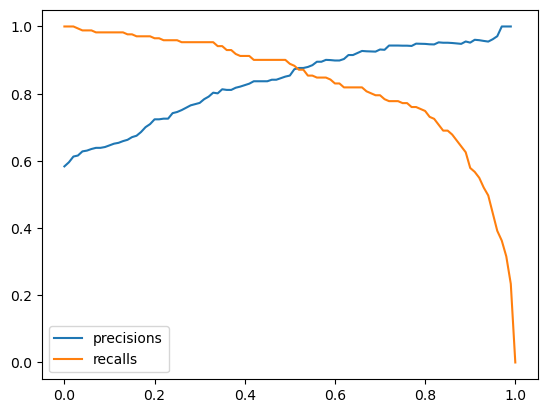

In [70]:
plt.plot(thresholds, precisions, label='precisions')
plt.plot(thresholds, recalls, label='recalls')
plt.legend()

In [80]:
f1_dict = {}
for i in range(len(thresholds)):
    t = thresholds[i]
    p = precisions[i]
    r = recalls[i]
    f1_dict[float(t)] = float(round(2 * p * r / (p+r), 3))
print(max(f1_dict, key = f1_dict.get))
print(f1_dict[0.51])
print(f1_dict.values())

0.51
0.878
dict_values([0.737, 0.747, 0.76, 0.761, 0.768, 0.77, 0.773, 0.774, 0.774, 0.776, 0.78, 0.783, 0.785, 0.789, 0.79, 0.795, 0.796, 0.804, 0.814, 0.82, 0.827, 0.827, 0.826, 0.826, 0.837, 0.839, 0.84, 0.845, 0.849, 0.851, 0.853, 0.86, 0.865, 0.872, 0.866, 0.873, 0.866, 0.866, 0.865, 0.864, 0.867, 0.869, 0.868, 0.868, 0.868, 0.868, 0.87, 0.87, 0.873, 0.875, 0.871, 0.878, 0.874, 0.874, 0.866, 0.869, 0.871, 0.871, 0.873, 0.87, 0.863, 0.863, 0.859, 0.864, 0.864, 0.867, 0.87, 0.862, 0.859, 0.855, 0.858, 0.851, 0.853, 0.853, 0.853, 0.849, 0.849, 0.841, 0.844, 0.84, 0.837, 0.825, 0.821, 0.812, 0.8, 0.8, 0.792, 0.779, 0.767, 0.756, 0.72, 0.713, 0.699, 0.674, 0.654, 0.608, 0.558, 0.532, 0.48, 0.379, nan])


In [81]:
from sklearn.model_selection import KFold

In [85]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv,  model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [88]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
aucs = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train_k = df_full_train.iloc[train_idx]
    df_val_k = df_full_train.iloc[val_idx]
    y_train_k = df_train_k.converted.values
    y_val_k = df_val_k.converted.values

    dv, model = train(df_train_k, y_train_k)
    y_pred_k = predict(df_val_k, dv, model)

    auc = roc_auc_score(y_val_k, y_pred_k)
    aucs.append(auc)

print(np.std(aucs))


0.03580711942905165


In [89]:
Cs = [0.000001, 0.001, 1]
aucs_dict = {}
for C in Cs:

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    aucs = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train_k = df_full_train.iloc[train_idx]
        df_val_k = df_full_train.iloc[val_idx]
        y_train_k = df_train_k.converted.values
        y_val_k = df_val_k.converted.values

        dv, model = train(df_train_k, y_train_k, C)
        y_pred_k = predict(df_val_k, dv, model)

        auc = roc_auc_score(y_val_k, y_pred_k)
        aucs.append(auc)

    aucs_dict[C] = (np.mean(aucs), np.std(aucs))

print(aucs_dict)

{1e-06: (np.float64(0.560207852870275), np.float64(0.023798316620649906)), 0.001: (np.float64(0.8668780317675395), np.float64(0.028746230508215103)), 1: (np.float64(0.8221089148573075), np.float64(0.03580711942905165))}
